# Early Intervention Efficacy Model

In [1]:
# Import modules and set options
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(context='notebook', style='ticks')

Import data

In [2]:
lsl_dr = (pd.read_csv('../data/clean/lsl_dr.csv', index_col=0, low_memory=False)
                  .rename({'onset_1':'identify_mo'}, axis=1))

In [3]:
lsl_dr.head()

,redcap_event_name,academic_year_rv,hl,male,_race,prim_lang,sib,_mother_ed,father_ed,par1_ed,...,gf3_sis_ss,gf3_siw_ss,gf_version,ppvt_f,ppvt_ss,rowpvt_ss,school,score,test_name,test_type
0,initial_assessment_arm_1,2002.0,0.0,0.0,0.0,0.0,1.0,6.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,101,58.0,NaN,EOWPVT
1,initial_assessment_arm_1,2002.0,0.0,0.0,0.0,0.0,1.0,6.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,101,51.0,PLS,receptive
2,initial_assessment_arm_1,2002.0,0.0,0.0,0.0,0.0,1.0,6.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,101,60.0,PLS,expressive
3,initial_assessment_arm_1,2009.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,628,74.0,NaN,Goldman
4,initial_assessment_arm_1,2009.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,628,96.0,CELF-4,receptive


Indicator for non-profound hearing loss

In [4]:
lsl_dr['deg_hl_below6'] = lsl_dr.degree_hl<6
lsl_dr.loc[lsl_dr.degree_hl.isnull(), 'deg_hl_below6'] = np.nan

Indicator for first intervention outside OPTION

In [5]:
lsl_dr['int_outside_option'] = lsl_dr.age > lsl_dr.age_int
lsl_dr.loc[lsl_dr.age < lsl_dr.age_int, 'int_outside_option'] = np.nan

Indicator for high school graduation of mother

In [6]:
lsl_dr['mother_hs'] = lsl_dr.mother_ed > 1
lsl_dr.loc[lsl_dr.mother_ed.isnull(), 'mother_hs'] = None

Create age in years variable

In [7]:
lsl_dr['age_years'] = lsl_dr.age/12.

Create school index

In [8]:
schools_unique = np.sort(lsl_dr.school.unique())
school_lookup = dict(zip(schools_unique, range(len(schools_unique))))

In [9]:
lsl_dr['school_idx'] = lsl_dr.school.replace(school_lookup)

Create student index

In [10]:
student_unique = np.sort(lsl_dr.study_id.unique())
student_lookup = dict(zip(student_unique, range(len(student_unique))))

In [11]:
lsl_dr['student_idx'] = lsl_dr.study_id.replace(student_lookup)

### Exclusions

Drop non-english and other disabilities, filter for hearing loss

In [12]:
other_etiology = (lsl_dr[['etiology_3___2', 'etiology_3___4', 'etiology_3___5', 'etiology_3___6', 'etiology_3___9',
       'etiology_oth___1', 'etiology_oth___3', 'etiology_oth___4', 'etiology_oth___8', 'etiology_oth___9']]
                      .sum(1).astype(bool))

In [13]:
inclusion_mask = (~lsl_dr.non_english.astype(bool) 
                  & ~lsl_dr.synd_or_disab.astype(bool) 
                  & (lsl_dr.degree_hl!=0)
                  & ((lsl_dr.etiology_2==0)
                  | (lsl_dr.etiology_2.isnull() & ~other_etiology)))

In [32]:
covariates = ['score', 'student_idx', 'school_idx', 'male', 'sib', 'family_inv', 'race', 'age_test', 
              'domain', 'deg_hl_below6', 'mother_hs', 'age_years', 'test_type', 'time']

In [37]:
analysis_subset = lsl_dr.loc[inclusion_mask, covariates].copy().dropna(subset=['time'])
analysis_subset.shape

(8156, 14)

## Summary Statistics

In [38]:
unique_students = analysis_subset.drop_duplicates(subset='student_idx')
unique_students.shape

(983, 14)

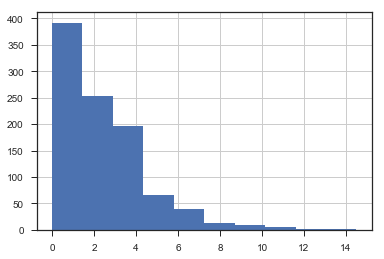

In [39]:
unique_students.age_years.hist()

In [40]:
unique_students.male.mean()

0.49643947100712105

In [41]:
unique_students.domain.value_counts()

Articulation             458
Language                 328
Expressive Vocabulary    190
Receptive Vocabulary       7
Name: domain, dtype: int64

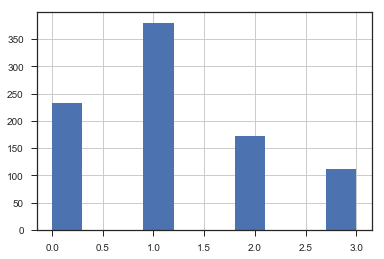

In [42]:
unique_students.sib.hist()

In [43]:
unique_students.deg_hl_below6.mean()

0.5595913734392736

In [44]:
unique_students.mother_hs.mean()

0.5597014925373134

Add expressive and receptive to langauge test domains

In [45]:
analysis_subset.loc[(analysis_subset.domain=='Language') & (analysis_subset.test_type=='receptive'), 
           'domain'] = 'Receptive Language'
analysis_subset.loc[(analysis_subset.domain=='Language') & (analysis_subset.test_type=='expressive'), 
           'domain'] = 'Expressive Language'

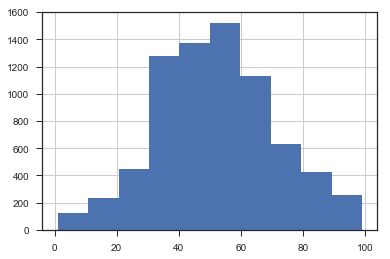

In [46]:
analysis_subset[analysis_subset.age_test<100].age_test.hist()

In [47]:
(analysis_subset.isnull().sum() / analysis_subset.shape[0]).round(2)

score            0.00
student_idx      0.00
school_idx       0.00
male             0.00
sib              0.06
family_inv       0.16
race             0.02
age_test         0.00
domain           0.00
deg_hl_below6    0.07
mother_hs        0.29
age_years        0.00
test_type        0.00
time             0.00
dtype: float64

Drop records with missing race and age at ernollment, since there is less than 1% of them

In [48]:
analysis_subset = analysis_subset.dropna(subset=['race', 'age_years'])

In [49]:
analysis_subset.race.value_counts()

0.0    5212
1.0     986
2.0     738
4.0     707
3.0     295
Name: race, dtype: int64

## Receptive Language Test Score Model

In [50]:
receptive_language_dataset = analysis_subset[(analysis_subset.domain=='Receptive Language')]

receptive_language_dataset.head()

,score,student_idx,school_idx,male,sib,family_inv,race,age_test,domain,deg_hl_below6,mother_hs,age_years,test_type,time
19,85.0,2914,26,1.0,1.0,2.0,0.0,63.0,Receptive Language,1.0,NaN,0.250000,receptive,4.0
220,81.0,2868,24,1.0,3.0,0.0,0.0,44.0,Receptive Language,1.0,1.0,3.666667,receptive,0.0
256,67.0,3040,26,0.0,3.0,2.0,2.0,53.0,Receptive Language,1.0,0.0,3.583333,receptive,1.0
258,50.0,3059,26,1.0,3.0,2.0,2.0,41.0,Receptive Language,0.0,0.0,1.666667,receptive,0.0
364,102.0,2647,23,1.0,0.0,1.0,4.0,8.0,Receptive Language,1.0,NaN,0.000000,receptive,0.0


This is the size of the resulting dataset to be used in this analysis

In [51]:
receptive_language_dataset.shape

(1670, 14)

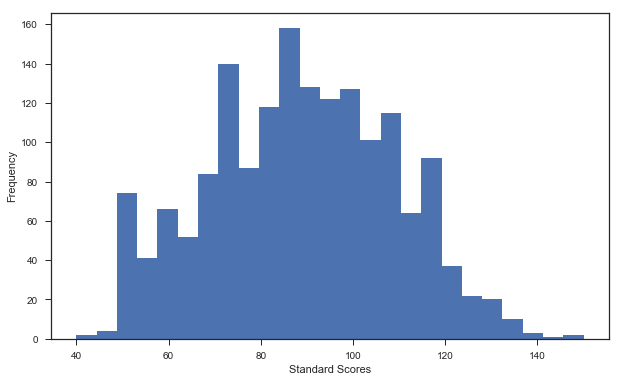

In [52]:
receptive_language_dataset.score.hist(grid=False, bins=25, figsize=(10, 6))
plt.xlabel('Standard Scores'); plt.ylabel('Frequency');

Final analysis dataset size

In [53]:
receptive_language_dataset.shape

(1670, 14)

In [54]:
receptive_language_dataset.race.value_counts()

0.0    1094
1.0     239
2.0     159
4.0     120
3.0      58
Name: race, dtype: int64

In [55]:
def fillna(x, value):
    x_masked = np.ma.masked_invalid(x)
    np.ma.set_fill_value(x_masked, value)
    return x_masked

fillna(np.array([0.4, np.nan, 5]), 0.5)

masked_array(data=[0.4, --, 5.0],
             mask=[False,  True, False],
       fill_value=0.5)

In [58]:
from pymc3 import Bernoulli, Normal, Uniform, Dirichlet, Categorical, Beta, HalfCauchy, Exponential, Multinomial
from pymc3 import Model, Deterministic, Metropolis
from numpy.ma import masked_values, set_fill_value, masked_invalid
import theano.tensor as tt
from theano import shared

def generate_model(dataset, cohort_age):
    
    if cohort_age==2:
        mask = (dataset.age_test>=24) & (dataset.age_test<36)
    elif cohort_age==3:
        mask = (dataset.age_test>=36) & (dataset.age_test<48)
    elif cohort_age==4:
        mask = (dataset.age_test>=48) & (dataset.age_test<60)
    elif cohort_age==5:
        mask = (dataset.age_test>=60) & (dataset.age_test<72)
    elif cohort_age==6:
        mask = (dataset.age_test>=72) & (dataset.age_test<84)
    else:
        print('Invalid age!')
        return
    
    # Generate mean scores
    mean_scores = dataset[mask].groupby('student_idx').score.mean()
    dataset_unique = dataset[mask].drop_duplicates(subset='student_idx')
    dataset_unique.set_index('student_idx').drop('score', axis=1).join(mean_scores)
    assert not dataset_unique.score.isnull().sum()
    
    (male, sib, family_inv, race, school, time,
             non_severe, mom_hs, age_enroll, score) = dataset_unique[['male', 'sib','family_inv', 'race', 'school_idx',
                                                    'time', 'deg_hl_below6', 'mother_hs', 
                                                    'age_years', 'score']].T.values
    
    # Transform some data
    age_enroll_std = age_enroll - age_enroll.mean()

    with Model() as model:

        # Imputation of family involvement
        if np.isnan(family_inv).sum():
            p_family_inv = Dirichlet("p_family_inv", np.ones(5))
            x_family_inv = Categorical('x_family_inv', p_family_inv, 
                                       observed=masked_invalid(family_inv))
        else:
            x_family_inv = family_inv
        
        # Imputation of hearing loss
        if np.isnan(non_severe).sum():
            p_hl = Beta("p_hl", 1, 1, testval=0.9)
            x_hl = Bernoulli('x_hl', p_hl, observed=masked_invalid(non_severe))
        else:
            x_hl = non_severe
            
        # Imputation of maternal education
        if np.isnan(mom_hs).sum():
            p_mother_hs = Beta("p_mother_hs", 1, 1)
            x_mother_hs = Bernoulli('x_mother_hs', p_mother_hs, 
                                    observed=masked_values(fillna(mom_hs, 0.5), value=0.5))
        else:
            x_mother_hs = mom_hs

        # Imputation of siblings
        if np.isnan(sib).sum():
            n_sib_cats = len(dataset.sib.unique())
            p_sib = Dirichlet("p_sib", np.ones(n_sib_cats))
            x_sib = Categorical('x_sib', p_sib, observed=masked_values(fillna(sib, 0.5), value=0.5))
        else:
            x_sib = sib
            
        # Indices to school random effects
        unique_schools = np.unique(school)
        school_index = [list(unique_schools).index(s) for s in school]

        # School random effect
        μ_school = Normal('μ_school', 90, sd=10)
        σ_school = Exponential("σ_school", 1)
        z_school = Normal('z_school', mu=0, sd=1, shape=len(unique_schools))
        α_school = Deterministic("α_school", μ_school + z_school*σ_school)
        
        # Random intercepts
        intercept = α_school[school_index]
        
        # Race effect
        β_race = Normal("β_race", 0, sd=10, shape=4)
        race_effect = tt.concatenate([[0], β_race])[race.astype(int)]
        
        X = [male, x_family_inv, x_sib, x_hl, x_mother_hs, age_enroll_std, time]
        # Fixed effects
        β = Normal("β", 0, sd=100, shape=len(X))
        θ = intercept + race_effect + β.dot(tt.stack(X))
    
        σ = HalfCauchy("σ", 1, testval=100)
        score_like = Normal("score_like", mu=θ, sd=σ, observed=score)
        
        # Predictions:
        [male, x_family_inv, x_sib, x_hl, x_mother_hs, age_enroll_std]
        # Caucasian girl, normal family involvement, 
        # 2 siblings, non-profound hearing loss,
        # mother with HS, average age
        # 2 years in program
        x1 = [0, 1, 2, 1, 1, 0, 2]

        # Hispanic boy, ideal family involvement, 
        # no siblings, profound hearing loss,
        # mother without HS diploma, 6 months younger than average
        # 1 year in program
        x2 = [1, 0, 0, 1, 0, -0.5, 1]

        # Black boy, poor family involvement, 
        # 1 sibling, non-profound hearing loss,
        # mother without HS diploma, 1.5 years older than average
        # 6 years in program
        x3 = [1, 4, 1, 0, 0, 1.5, 6]

        # Black girl, impaired family involvement, 
        # 3 siblings, profound hearing loss,
        # mother with HS diploma, 6 months older than average
        # 3 years in program
        x4 = [0, 3, 3, 1, 1, 0.5, 3]

        X_new = tt.stack([x1, x2, x3, x4])

        θ_pred = μ_school + β.dot(X_new.T) + β_race[np.array([0,2,1,1])]
        predictions = Normal('predictions', mu=θ_pred, sd=σ, shape=4)
    
    return model

### Making predictions

Though these models were constructed primarily for inference, that is, to provide insights on the relative effects of a suite of factors on expected test scores, there is the potential for using them to predict speech-language outcomes. To explore this, we contrived four predictive scenarios, whereby children with different values of the set of predictor variables were specified, and predictions for them were generated by our models. 

The Bayesian hierarchical modeling approach makes generating predictions straightforward, via the posterior predictive distribution, which generates predicted values of outcomes conditional on the outcomes observed in the dataset. The variation of these predictions includes both the residual uncertainty in the model parameters and the aleatory sampling variability of the test outcomes. Our test cases were specified as follows:

**Case 1** 👧

* female
* average age
* normal family involvement
* 2 siblings
* non-profound hearing loss
* mother with HS
* no previous disability
* JCIH criterion met

**Case 2** 👦

* male 
* 6 months younger than average
* normal family involvement
* no siblings
* profound hearing loss
* mother without HS diploma
* previous disability
* JCIH criterion met

**Case 3** 👶

* male 
* 1.5 years older than average
* poor family involvement
* 1 sibling
* non-profound hearing loss
* mother without HS diploma
* previous disability
* no JCIH

**Case 4** 🙎

* female 
* 6 months older than average
* impaired family involvement
* 3 siblings
* profound hearing loss
* mother with HS diploma
* no previous disability
* JCIH criterion met

In [59]:
receptive_language_4 = generate_model(receptive_language_dataset, 4)

In [60]:
iterations = 1000
tuning = 2000

In [61]:
from pymc3 import sample

with receptive_language_4:
    
    trace = sample(iterations, tune=tuning, nuts_kwargs={'target_accept': 0.9})

/Users/fonnescj/Repos/pymc3/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [predictions, σ_log__, β, β_race, z_school, σ_school_log__, μ_school, p_sib_stickbreaking__, p_mother_hs_logodds__, p_hl_logodds__, p_family_inv_stickbreaking__]
>CategoricalGibbsMetropolis: [x_sib_missing, x_family_inv_missing]
>BinaryGibbsMetropolis: [x_hl_missing, x_mother_hs_missing]
 98%|█████████▊| 2950/3000 [04:28<00:05,  9.19it/s]/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|█████████▉| 2999/3000 [04:32<00:00, 17.63it/s]/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty

In [62]:
labels = ['Male', 
          'Family Involvement Score', 
          'Sibling Count',
          'Non-profound Hearing Loss',
          'Mother with HS Diploma',
          'Age at enrollment',
          'Years in program']

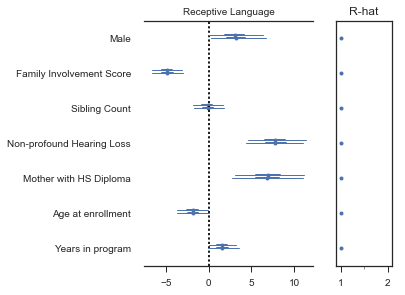

In [64]:
from pymc3 import forestplot

forestplot(trace, varnames=['β'], ylabels=labels, main='Receptive Language')

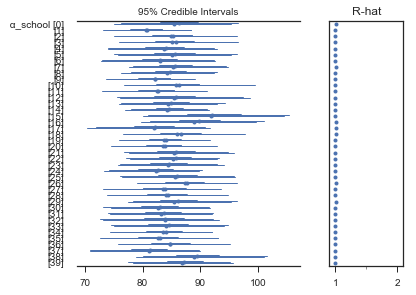

In [65]:
forestplot(trace, varnames=['α_school'])

In [66]:
from pymc3 import effective_n

effective_n(trace)

{'p_family_inv': array([1734., 2000., 1709., 2000., 2000.]),
 'p_hl': 2000.0,
 'p_mother_hs': 2000.0,
 'p_sib': array([2000., 2000., 2000., 2000., 2000.]),
 'predictions': array([2000., 2000., 2000., 2000.]),
 'x_family_inv_missing': array([ 975.,  593., 1147., 1532., 1315.,  517., 1221., 1589., 2000.,
         870., 1136., 1021.,  988., 1519.,  809., 1541., 2000., 1363.,
        1031.,  844.,  635., 1731., 1587.,  894., 1075., 1499.,  718.,
        1605.,  681., 1451., 1611., 1329.,  464., 1204., 1224., 1652.,
        1599.,  561., 1889.,  737., 1663., 1020.,  613.,  843.,  593.,
        1468., 1978.,  932.]),
 'x_hl_missing': array([2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
        2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
        2000., 2000., 2000., 2000., 2000., 2000.]),
 'x_mother_hs_missing': array([2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
        2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
      

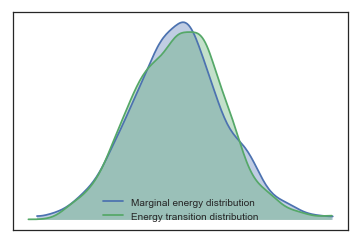

In [67]:
from pymc3 import energyplot

energyplot(trace)

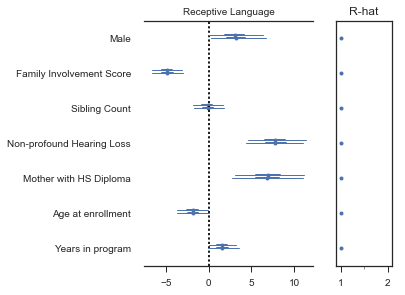

In [68]:
forestplot(trace, varnames=['β'], ylabels=labels, main='Receptive Language')

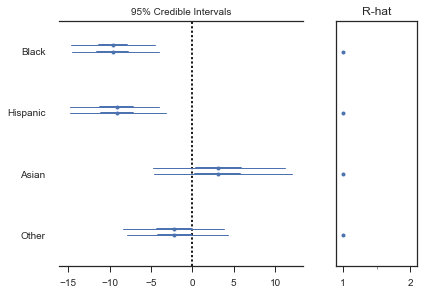

In [69]:
forestplot(trace, varnames=['β_race'], ylabels=['Black', 'Hispanic', 'Asian', 'Other'])

The school random effect standard deviation is a measure of how variable scores are among schools. The estimated standard deviation is about 4 points for this domain.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12a5b0860>,
      dtype=object)

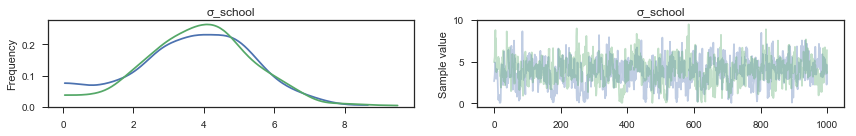

In [70]:
from pymc3 import traceplot

traceplot(trace, varnames=['σ_school'])

In [71]:
from pymc3 import summary

summary(trace, varnames=['β']).set_index(pd.Index(labels))

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Male,3.118428,1.658945,0.031435,0.096259,6.576899,2000.0,1.000555
Family Involvement Score,-4.863427,0.926304,0.031530,-6.669373,-3.058551,721.0,1.001218
Sibling Count,-0.111470,0.908787,0.021679,-1.833621,1.730661,1539.0,1.000488
Non-profound Hearing Loss,7.798649,1.751248,0.032696,4.365631,11.159444,2000.0,0.999737
Mother with HS Diploma,6.877655,2.113253,0.049783,2.818385,11.010406,1839.0,0.999783
Age at enrollment,-1.841493,0.952984,0.024680,-3.674097,0.094829,1333.0,0.999783
Years in program,1.611320,0.884135,0.024428,-0.039605,3.327937,1245.0,1.000626


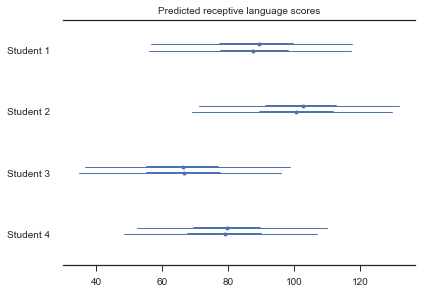

In [72]:
forestplot(trace, varnames=["predictions"], rhat=False, 
           ylabels=['Student {}'.format(i) for i in range(1,5)],
           main='Predicted receptive language scores');

## Expressive Language Model

In [73]:
expressive_language_dataset = analysis_subset[(analysis_subset.domain=='Expressive Language')]

In [74]:
expressive_language_4 = generate_model(expressive_language_dataset, 4)

In [75]:
with expressive_language_4:
    
    exp_lang_4_trace = sample(iterations, tune=tuning)

/Users/fonnescj/Repos/pymc3/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [predictions, σ_log__, β, β_race, z_school, σ_school_log__, μ_school, p_sib_stickbreaking__, p_mother_hs_logodds__, p_hl_logodds__, p_family_inv_stickbreaking__]
>CategoricalGibbsMetropolis: [x_sib_missing, x_family_inv_missing]
>BinaryGibbsMetropolis: [x_hl_missing, x_mother_hs_missing]
100%|█████████▉| 2988/3000 [03:19<00:00, 17.66it/s]/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 3000/3000 [03:20<00:00, 15.55it/s]/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty

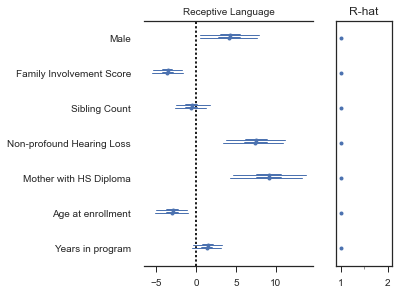

In [76]:
forestplot(exp_lang_4_trace, varnames=['β'], ylabels=labels, main='Receptive Language')

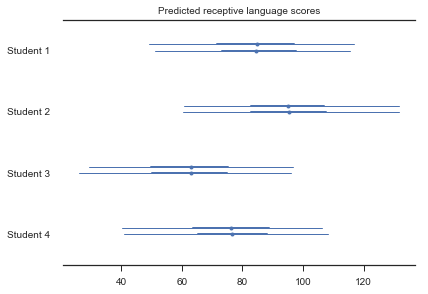

In [77]:
forestplot(exp_lang_4_trace, varnames=["predictions"], rhat=False, 
           ylabels=['Student {}'.format(i) for i in range(1,5)],
           main='Predicted receptive language scores')

## Articulation Model

In [78]:
articulation_dataset = analysis_subset[(analysis_subset.domain=='Articulation')]

In [79]:
articulation_4 = generate_model(articulation_dataset, 4)

In [80]:
with articulation_4:
    
    artic_4_trace = sample(iterations, tune=tuning)

/Users/fonnescj/Repos/pymc3/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [predictions, σ_log__, β, β_race, z_school, σ_school_log__, μ_school, p_sib_stickbreaking__, p_mother_hs_logodds__, p_hl_logodds__, p_family_inv_stickbreaking__]
>CategoricalGibbsMetropolis: [x_sib_missing, x_family_inv_missing]
>BinaryGibbsMetropolis: [x_hl_missing, x_mother_hs_missing]
100%|█████████▉| 2998/3000 [03:05<00:00, 16.86it/s]/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 3000/3000 [03:06<00:00, 16.69it/s]/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty

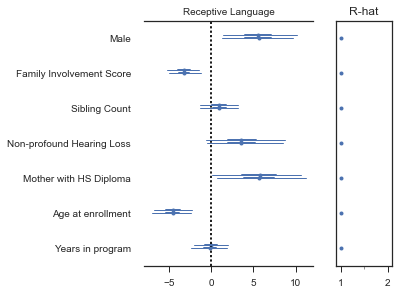

In [81]:
forestplot(artic_4_trace, varnames=['β'], ylabels=labels, main='Receptive Language')

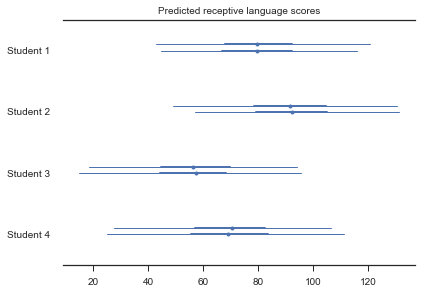

In [82]:
forestplot(artic_4_trace, varnames=["predictions"], rhat=False, 
           ylabels=['Student {}'.format(i) for i in range(1,5)],
           main='Predicted receptive language scores')

## Expressive Vocabulary Model

In [83]:
expressive_vocab_dataset = analysis_subset[(analysis_subset.domain=='Expressive Vocabulary')]

In [84]:
expressive_vocab_4 = generate_model(expressive_vocab_dataset, 4)

In [85]:
with expressive_vocab_4:
    
    expressive_vocab_4_trace = sample(iterations, tune=tuning)

/Users/fonnescj/Repos/pymc3/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [predictions, σ_log__, β, β_race, z_school, σ_school_log__, μ_school, p_sib_stickbreaking__, p_mother_hs_logodds__, p_hl_logodds__, p_family_inv_stickbreaking__]
>CategoricalGibbsMetropolis: [x_sib_missing, x_family_inv_missing]
>BinaryGibbsMetropolis: [x_hl_missing, x_mother_hs_missing]
100%|█████████▉| 2989/3000 [04:01<00:00, 12.60it/s]/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|█████████▉| 2999/3000 [04:02<00:00, 13.23it/s]/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty

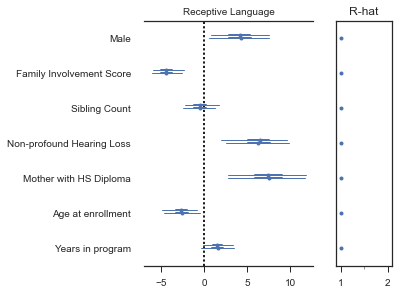

In [86]:
forestplot(expressive_vocab_4_trace, varnames=['β'], ylabels=labels, main='Receptive Language')

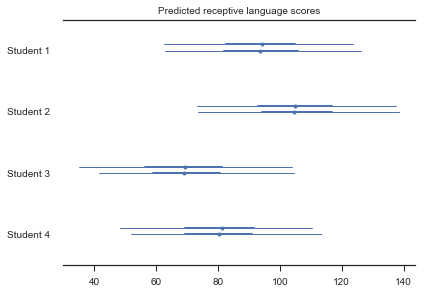

In [87]:
forestplot(expressive_vocab_4_trace, varnames=["predictions"], rhat=False, 
           ylabels=['Student {}'.format(i) for i in range(1,5)],
           main='Predicted receptive language scores')

## Receptive Vocabulary Model

In [88]:
receptive_vocab_dataset = analysis_subset[(analysis_subset.domain=='Receptive Vocabulary')]

In [89]:
receptive_vocab_4 = generate_model(receptive_vocab_dataset, 4)

In [90]:
with receptive_vocab_4:
    
    receptive_vocab_4_trace = sample(iterations, tune=tuning)

/Users/fonnescj/Repos/pymc3/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [predictions, σ_log__, β, β_race, z_school, σ_school_log__, μ_school, p_sib_stickbreaking__, p_mother_hs_logodds__, p_hl_logodds__, p_family_inv_stickbreaking__]
>CategoricalGibbsMetropolis: [x_sib_missing, x_family_inv_missing]
>BinaryGibbsMetropolis: [x_hl_missing, x_mother_hs_missing]
 99%|█████████▊| 2958/3000 [04:10<00:02, 14.20it/s]/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 3000/3000 [04:13<00:00, 14.30it/s]/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty

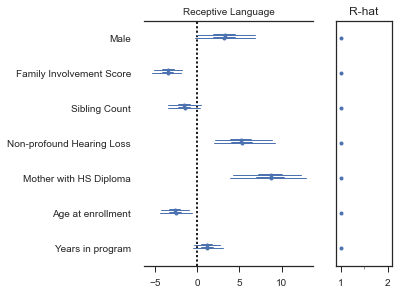

In [91]:
forestplot(receptive_vocab_4_trace, varnames=['β'], ylabels=labels, main='Receptive Language')

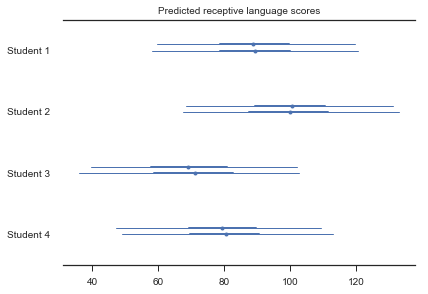

In [92]:
forestplot(receptive_vocab_4_trace, varnames=["predictions"], rhat=False, 
           ylabels=['Student {}'.format(i) for i in range(1,5)],
           main='Predicted receptive language scores')